In [ ]:
!pip install -q speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Load Test Input Data
!gdown --folder https://drive.google.com/drive/folders/1NX0Ax1zdcrtJDTpIRQtbJWwmxK2rfeGy

Retrieving folder contents
Processing file 1-0MTQct6kOHOwUpbRI-F3zwSuuxRZQW8 Mrbeast_sound.wav
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-0MTQct6kOHOwUpbRI-F3zwSuuxRZQW8
To: /content/Test Sound/Mrbeast_sound.wav
100% 1.50M/1.50M [00:00<00:00, 58.8MB/s]
Download completed


In [ ]:
input_audio = "/content/Test Sound/Mrbeast_sound.wav"

# Conformer by ฉันเอง

In [ ]:
import torch
import torch.nn as nn

# --- 1. FeedForward Module (Macaron-style) ---
# FFN = Linear → Activation(Swish) → Linear → Dropout
class FeedForwardModule(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.SiLU()  # Swish = x * sigmoid(x)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.linear2(self.activation(self.linear1(x))))

# --- 2. Multi-Head Self-Attention (MHSA) ---
# global context + relative positional encoding
class SelfAttentionModule(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads,
                                          dropout=dropout, batch_first=True)

    def forward(self, x):
        return self.attn(x, x, x)[0]  # x: [B, T, D]

# --- 3. Convolution Module ---
# Conv1D + GLU → DepthwiseConv → BN → Swish → Conv1D
# local acoustic pattern
class ConvolutionModule(nn.Module):
    def __init__(self, d_model, kernel_size=15, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.pw1 = nn.Conv1d(d_model, 2 * d_model, 1)  # Pointwise conv
        self.glu = nn.GLU(dim=1)
        self.dw = nn.Conv1d(d_model, d_model, kernel_size,
                            padding=kernel_size // 2, groups=d_model)  # Depthwise
        self.bn = nn.BatchNorm1d(d_model)
        self.act = nn.SiLU()  # Swish
        self.pw2 = nn.Conv1d(d_model, d_model, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm(x).transpose(1, 2)  # [B, D, T]
        x = self.glu(self.pw1(x))        # gating
        x = self.act(self.bn(self.dw(x)))
        x = self.dropout(self.pw2(x))
        return x.transpose(1, 2)  # back to [B, T, D]

# --- 4. Conformer Block ---
# FFN(1) + MHSA + Conv + FFN(2) + Final LayerNorm
class ConformerBlock(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, kernel_size, dropout=0.1):
        super().__init__()
        self.ffn1 = FeedForwardModule(d_model, d_ff, dropout)
        self.mhsa = SelfAttentionModule(d_model, n_heads, dropout)
        self.conv = ConvolutionModule(d_model, kernel_size, dropout)
        self.ffn2 = FeedForwardModule(d_model, d_ff, dropout)
        self.final_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + 0.5 * self.ffn1(x)  # Macaron FFN #1
        x = x + self.mhsa(x)        # MHSA
        x = x + self.conv(x)        # Conv block
        x = x + 0.5 * self.ffn2(x)  # Macaron FFN #2
        return self.final_norm(x)

# --- 5. CTC Decoder ---
# Linear → LogSoftmax
class CTCDecoder(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.log_softmax(self.proj(x))

# --- 6. Full Model: Conformer Encoder + CTC Decoder ---
class ConformerASRModel(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, kernel_size, vocab_size):
        super().__init__()
        self.encoder = ConformerBlock(d_model, d_ff, n_heads, kernel_size)
        self.decoder = CTCDecoder(d_model, vocab_size)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
import torch
import torchaudio
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.nn import CTCLoss
from tqdm import tqdm

# Load LibriSpeech subset (for demo)
dataset = torchaudio.datasets.LIBRISPEECH(".", url="test-clean", download=True)

# Tokenizer (char-level + blank)
char_list = ["_"] + list("abcdefghijklmnopqrstuvwxyz ")  # 0 = blank
char2idx = {c: i for i, c in enumerate(char_list)}
index2char = char_list
def tokenize(text):
    if not isinstance(text, str):
        text = str(text)
    return torch.tensor([char2idx[c] for c in text.lower() if c in char2idx], dtype=torch.long)

# Collate
def collate_fn(batch):
    waveforms, targets = [], []
    for waveform, _, _, transcript, _, _ in batch:
        waveforms.append(waveform.mean(0, keepdim=True))
        targets.append(tokenize(transcript))
    return waveforms, targets

# DataLoader
loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Model
model = ConformerASRModel(d_model=80, d_ff=320, n_heads=4, kernel_size=15, vocab_size=len(index2char))
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = CTCLoss(blank=0, zero_infinity=True)
transform = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=80)

# Train loop (1 epoch demo)
model.train()
epochs = 1
num_batches = len(loader)
total_steps = epochs * num_batches

pbar = tqdm(total=total_steps, desc="Training", unit="step")

for epoch in range(epochs):
    for waveforms, targets in loader:
        feats = [transform(w).squeeze(0).T for w in waveforms]
        inputs = pad_sequence(feats, batch_first=True)
        input_lengths = torch.tensor([f.shape[0] for f in feats])
        targets_cat = torch.cat(targets)
        target_lengths = torch.tensor([len(t) for t in targets])

        log_probs = model(inputs).transpose(0, 1)
        loss = criterion(log_probs, targets_cat, input_lengths, target_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_postfix({
            "epoch": f"{epoch+1}/{epochs}",
            "loss": f"{loss.item():.4f}"
        })

pbar.close()

100%|██████████| 331M/331M [00:17<00:00, 20.4MB/s]
/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|██████████| 1310/1310 [06:56<00:00,  3.14step/s, epoch=1/1, loss=0.0497]


In [ ]:
# ✅ Save model weights
torch.save(model.state_dict(), "conformer_model.pt")
print("✅ Model weights saved to conformer_model.pt")

✅ Model weights saved to conformer_model.pt


In [ ]:
import torch
import torchaudio

# 1. Put encoder in eval mode
model.eval()

# 2. Grab one example from LibriSpeech
waveform, _, _, transcript, _, _ = dataset[0]
waveform = waveform.mean(0, keepdim=True)   # to mono

# 3. Resample & featurize exactly as in training
sr = 16000
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)
# (If sr != 16k, apply Resample here)

feats = transform(waveform)                 # [1, n_mfcc, T]
feats = feats.squeeze(0).T.unsqueeze(0)     # → [1, T, 80]

# 4. Run through encoder only
with torch.no_grad():
    enc_out = model.encoder(feats)           # [1, T, d_model]

print("Encoder output shape:", enc_out.shape)

Encoder output shape: torch.Size([1, 835, 80])


In [ ]:
import matplotlib.pyplot as plt

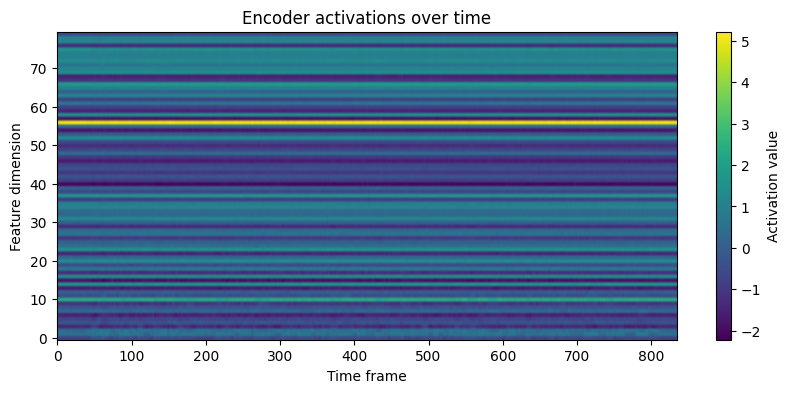

In [ ]:
# pick the first (and only) batch:
feat_matrix = enc_out[0].cpu().numpy().T  # shape [80, T]

plt.figure(figsize=(10, 4))
plt.imshow(feat_matrix, aspect='auto', origin='lower')
plt.xlabel('Time frame')
plt.ylabel('Feature dimension')
plt.title('Encoder activations over time')
plt.colorbar(label='Activation value')
plt.show()

In [ ]:
import torch
import torchaudio

model.eval()
transform = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=80)

# Greedy decode helper
def ctc_greedy_decode(log_probs, index2char, blank=0):
    preds = torch.argmax(log_probs, dim=-1)[0].tolist()
    out, prev = [], None
    for p in preds:
        if p != prev and p != blank:
            out.append(index2char[p])
        prev = p
    return ''.join(out)

# Test with .wav
def transcribe_wav(path, model, transform, index2char):
    # Load
    waveform, sr = torchaudio.load(path)    # waveform: [channels, T]
    # Mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    # Resample if needed
    if sr != 16000:
        waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=16000)
    # Featurize → [1, T, 80]
    feats = transform(waveform).squeeze(0).T.unsqueeze(0)
    # Forward
    with torch.no_grad():
        log_probs = model(feats)            # [1, T, V]
    # Decode
    transcript = ctc_greedy_decode(log_probs, index2char)
    return transcript

# See Result 👁️👄👁️
index2char  = ["_"] + list("abcdefghijklmnopqrstuvwxyz ")
print("Transcription:", transcribe_wav(input_audio, model, transform, index2char))


Transcription: 


In [ ]:
import torch

def inspect_probs(log_probs):
    # log_probs: [1, T, V]
    probs = torch.exp(log_probs)           # back to P
    blank_p = probs[:, :, 0].mean().item()
    top1_nonblank_p = probs[:, :, 1:].max(dim=-1).values.mean().item()
    print(f"Avg P(blank)     = {blank_p:.3f}")
    print(f"Avg max P(token) = {top1_nonblank_p:.3f}")

    # print a few timesteps
    for t in range(min(5, probs.shape[1])):
        row = probs[0, t]
        top5 = torch.topk(row, 5)
        tokens = [index2char[i] for i in top5.indices.tolist()]
        scores = [f"{p:.2f}" for p in top5.values.tolist()]
        print(f"t={t:2d}  {list(zip(tokens, scores))}")

In [ ]:
with torch.no_grad():
    log_probs = model(feats)   # [1, T, V]
inspect_probs(log_probs)

Avg P(blank)     = 1.000
Avg max P(token) = 0.000
t= 0  [('_', '1.00'), ('m', '0.00'), ('w', '0.00'), ('x', '0.00'), ('d', '0.00')]
t= 1  [('_', '1.00'), ('m', '0.00'), ('w', '0.00'), ('d', '0.00'), ('x', '0.00')]
t= 2  [('_', '1.00'), ('m', '0.00'), ('w', '0.00'), ('x', '0.00'), ('d', '0.00')]
t= 3  [('_', '1.00'), ('m', '0.00'), ('w', '0.00'), ('x', '0.00'), ('d', '0.00')]
t= 4  [('_', '1.00'), ('m', '0.00'), ('w', '0.00'), ('d', '0.00'), ('x', '0.00')]


In [ ]:
# import torch
# import torchaudio

# # vocab (index 0 = blank)
# index2char = ["_"] + list("abcdefghijklmnopqrstuvwxyz ")
# vocab_size = len(index2char)

# # Load Model
# model = ConformerASRModel(d_model=80, d_ff=320, n_heads=4, kernel_size=15, vocab_size=vocab_size)
# model.load_state_dict(torch.load("/content/conformer_model.pt"))  # << Load weights (From Training)
# model.eval()

# # Feature extractor
# transform = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=80)

# # Load .wav File
# waveform, sr = torchaudio.load(input_audio)

# if waveform.shape[0] > 1:
#     waveform = waveform.mean(dim=0, keepdim=True)

# # config sample rate
# if sr != 16000:
#     resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
#     waveform = resampler(waveform)

# # feature shape: [1, T, 80]
# features = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0)

# with torch.no_grad():
#     log_probs = model(features)  # shape: [1, T, vocab]

# # ------------------------------
# # Greedy Decode (No LM)
# def ctc_greedy_decode(log_probs, index2char):
#     preds = torch.argmax(log_probs, dim=-1)[0].tolist()
#     out, prev = [], None
#     for p in preds:
#         if p != prev and p != 0:
#             out.append(index2char[p])
#         prev = p
#     return ''.join(out)

# print("No LM:", ctc_greedy_decode(log_probs, index2char))

No LM: 


# Conformer-Pretrained Method

## ASR Conformer (Trained from librispeech Dataset)

Source: https://huggingface.co/speechbrain/asr-conformer-transformerlm-librispeech

In [ ]:
from speechbrain.inference import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-conformer-transformerlm-librispeech", savedir="pretrained_models/asr-transformer-transformerlm-librispeech")

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-transformerlm-librispeech' if not cached


hyperparams.yaml:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-transformerlm-librispeech/snapshots/eb981701f2831dae595e6d55ab02ed6080cd38d2/hyperparams.yaml' -> '/content/pretrained_models/asr-transformer-transformerlm-librispeech/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-transformerlm-librispeech' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBU

normalizer.ckpt:   0%|          | 0.00/1.70k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-transformerlm-librispeech/snapshots/eb981701f2831dae595e6d55ab02ed6080cd38d2/normalizer.ckpt' -> '/content/pretrained_models/asr-transformer-transformerlm-librispeech/normalizer.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["normalizer"] = /content/pretrained_models/asr-transformer-transformerlm-librispeech/normalizer.ckpt
INFO:speechbrain.utils.fetching:Fetch asr.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-transformerlm-librispeech' if not cached


asr.ckpt:   0%|          | 0.00/442M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-transformerlm-librispeech/snapshots/eb981701f2831dae595e6d55ab02ed6080cd38d2/asr.ckpt' -> '/content/pretrained_models/asr-transformer-transformerlm-librispeech/asr.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["asr"] = /content/pretrained_models/asr-transformer-transformerlm-librispeech/asr.ckpt
INFO:speechbrain.utils.fetching:Fetch lm.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-transformerlm-librispeech' if not cached


lm.ckpt:   0%|          | 0.00/381M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-transformerlm-librispeech/snapshots/eb981701f2831dae595e6d55ab02ed6080cd38d2/lm.ckpt' -> '/content/pretrained_models/asr-transformer-transformerlm-librispeech/lm.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["lm"] = /content/pretrained_models/asr-transformer-transformerlm-librispeech/lm.ckpt
INFO:speechbrain.utils.fetching:Fetch tokenizer.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-transformerlm-librispeech' if not cached


tokenizer.ckpt:   0%|          | 0.00/324k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-transformerlm-librispeech/snapshots/eb981701f2831dae595e6d55ab02ed6080cd38d2/tokenizer.ckpt' -> '/content/pretrained_models/asr-transformer-transformerlm-librispeech/tokenizer.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["tokenizer"] = /content/pretrained_models/asr-transformer-transformerlm-librispeech/tokenizer.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: normalizer, asr, lm, tokenizer
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): normalizer -> /content/pretrained_models/asr-transformer-transformerlm-librispeech/normalizer.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): asr -> /content/pretrained_models/asr-transformer-transformerlm-librispeech/asr.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (

In [ ]:
asr_model.transcribe_file(input_audio)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


"OH MY GOD OH MY GOD LET'S MISS OUR BASE"

## ASR Conformer (Trained from LargeScaleASR Dataset)

Source: https://huggingface.co/speechbrain/asr-conformer-largescaleasr

In [ ]:
from speechbrain.inference import EncoderDecoderASR

In [ ]:
# For a full decoding with a large beam size (can be slow):
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-conformer-largescaleasr", savedir="pretrained_models/asr-conformer-largescaleasr")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-largescaleasr' if not cached


hyperparams.yaml:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-largescaleasr/snapshots/eeb1c1fd655a463724b223ee5adec107b887f046/hyperparams.yaml' -> '/content/pretrained_models/asr-conformer-largescaleasr/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-largescaleasr' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/asr-conformer-largescaleasr.
INFO:speechbrain.utils.fetching:Fetch normalizer.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-largescaleasr' if not cached


normalizer.ckpt:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-largescaleasr/snapshots/eeb1c1fd655a463724b223ee5adec107b887f046/normalizer.ckpt' -> '/content/pretrained_models/asr-conformer-largescaleasr/normalizer.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["normalizer"] = /content/pretrained_models/asr-conformer-largescaleasr/normalizer.ckpt
INFO:speechbrain.utils.fetching:Fetch asr.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-largescaleasr' if not cached


asr.ckpt:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-largescaleasr/snapshots/eeb1c1fd655a463724b223ee5adec107b887f046/asr.ckpt' -> '/content/pretrained_models/asr-conformer-largescaleasr/asr.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["asr"] = /content/pretrained_models/asr-conformer-largescaleasr/asr.ckpt
INFO:speechbrain.utils.fetching:Fetch tokenizer.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-largescaleasr' if not cached


tokenizer.ckpt:   0%|          | 0.00/320k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--asr-conformer-largescaleasr/snapshots/eeb1c1fd655a463724b223ee5adec107b887f046/tokenizer.ckpt' -> '/content/pretrained_models/asr-conformer-largescaleasr/tokenizer.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["tokenizer"] = /content/pretrained_models/asr-conformer-largescaleasr/tokenizer.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: normalizer, asr, tokenizer
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): normalizer -> /content/pretrained_models/asr-conformer-largescaleasr/normalizer.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): asr -> /content/pretrained_models/asr-conformer-largescaleasr/asr.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): tokenizer -> /content/pretrained_models/asr-co

In [ ]:
# For even faster decoding
asr_model.transcribe_file(input_audio)

"OH MY GOD OH MY GOD IT'S MISTER BEAST"

In [ ]:
# For greedy decoding:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-conformer-largescaleasr", savedir="pretrained_models/asr-conformer-largescaleasr", overrides={"test_beam_size":1})

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/asr-conformer-largescaleasr/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-largescaleasr' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/asr-conformer-largescaleasr.
INFO:speechbrain.utils.fetching:Fetch normalizer.ckpt: Using symlink found at '/content/pretrained_models/asr-conformer-largescaleasr/normalizer.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["normalizer"] = /content/pretrained_models/asr-conformer-largescaleasr/normalizer.ckpt
INFO:speechbrain.utils.fetching:Fetch asr.ckpt: Using symlink found at '/content/pretrained_models/asr-conformer-largescaleasr/asr.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["asr"] = /content/pretrained_models/asr-conformer-lar

In [ ]:
# For even faster decoding
asr_model.transcribe_file(input_audio)

"OH MY GOD OH MY GOD IT'S MISTER BEAST"

In [ ]:
# For Attn. only decoding (faster):
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-conformer-largescaleasr", savedir="pretrained_models/asr-conformer-largescaleasr", overrides={"scorer":None, "ctc_weight_decode":0.0})

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/asr-conformer-largescaleasr/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/asr-conformer-largescaleasr' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/asr-conformer-largescaleasr.
INFO:speechbrain.utils.fetching:Fetch normalizer.ckpt: Using symlink found at '/content/pretrained_models/asr-conformer-largescaleasr/normalizer.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["normalizer"] = /content/pretrained_models/asr-conformer-largescaleasr/normalizer.ckpt
INFO:speechbrain.utils.fetching:Fetch asr.ckpt: Using symlink found at '/content/pretrained_models/asr-conformer-largescaleasr/asr.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["asr"] = /content/pretrained_models/asr-conformer-lar

In [ ]:
# For even faster decoding
asr_model.transcribe_file(input_audio)

"OH MY GOD OH MY GOD IT'S MISTER BEAST"